In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sensorium
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from nnfabrik.builder import get_data, get_model

from sensorium.utility import get_signal_correlations
from sensorium.utility.measure_helpers import get_df_for_scores

## Loading the dataloaders and the models for the autistic, wild-type and sensorium II(23964-4-22) datasets

In [2]:
seed=31415
autistic_mouse_dataPath = "../data/new_data2023/static29027-6-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
wildtype_mouse_dataPath = "../data/new_data2023/static29028-1-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
vanilla_dataPath = "../data/sensorium_data2022/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

In [3]:
dataset_a = "29027-6-17-1-6-5"
dataset_wt = "29028-1-17-1-6-5"
dataset_s = "23964-4-22"

In [4]:
dataset_fn = 'sensorium.datasets.static_loaders'

filenames_autistic = [autistic_mouse_dataPath, ]

dataset_config_autistic = {'paths': filenames_autistic,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':1,
                 }

dataloaders_autistic = get_data(dataset_fn, dataset_config_autistic)

filenames_wildtype = [wildtype_mouse_dataPath, ]

dataset_config_wildtype = {'paths': filenames_wildtype,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':1,
                 }

dataloaders_wildtype = get_data(dataset_fn, dataset_config_wildtype)

filenames_vanilla = [vanilla_dataPath, ]

dataset_config = {'paths': filenames_vanilla,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':0.25,
                 }

dataloaders_vanilla = get_data(dataset_fn, dataset_config)

In [5]:
model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
  'stack': -1,
  'layers': 4,
  'input_kern': 9,
  'gamma_input': 6.3831,
  'gamma_readout': 0.0076,
  'hidden_kern': 7,
  'hidden_channels': 64,
  'depth_separable': True,
  'grid_mean_predictor': {'type': 'cortex',
   'input_dimensions': 2,
   'hidden_layers': 1,
   'hidden_features': 30,
   'final_tanh': True},
  'init_sigma': 0.1,
  'init_mu_range': 0.3,
  'gauss_type': 'full',
  'shifter': False,
}

model_a = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_autistic,
                  seed=seed,
                  )

model_wt = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_wildtype,
                  seed=seed,
                  )
model_sensorium= get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_vanilla,
                  seed=seed,
                  )

In [6]:
model_a.load_state_dict(torch.load("./model_checkpoints/autistic_model.pth"))
model_wt.load_state_dict(torch.load("./model_checkpoints/wildtype_model.pth"))
model_sensorium.load_state_dict(torch.load("./model_checkpoints/sensorium23964-4-22.pth"))

<All keys matched successfully>

In [7]:
model_a.cuda().eval()
model_wt.cuda().eval()
model_sensorium.cuda().eval()

FiringRateEncoder(
  (core): Stacked2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64, bias=False)
          (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): 

## Loading the MEI tensors

In [8]:
meis_a = torch.load("MEIs/meis_a200.pt")
meis_wt = torch.load("MEIs/meis_wt200.pt")
meis_s = torch.load("MEIs/meis_s200.pt")
meis_combined = torch.from_numpy(np.vstack(meis_a + meis_wt)).cuda()
meis_swt = torch.from_numpy(np.vstack(meis_s + meis_wt)).cuda()

## Calculating the correlation-to-averages for each model and picking the top 200 neurons with the highest CTA.

In [9]:
correlation_to_average_a = get_signal_correlations(model_a, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
correlation_to_average_s = get_signal_correlations(model_sensorium, dataloaders_vanilla, tier="test", device="cuda", as_dict=True)
correlation_to_average_wt = get_signal_correlations(model_wt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
df_cta_a = get_df_for_scores(session_dict=correlation_to_average_a, measure_attribute="Correlation to Average")
df_cta_a["dataset"] = df_cta_a["dataset"].replace("29027-6-17-1-6-5", "Autistic")
df_cta_wt = get_df_for_scores(session_dict=correlation_to_average_wt, measure_attribute="Correlation to Average")
df_cta_wt["dataset"] = df_cta_wt["dataset"].replace("29028-1-17-1-6-5", "Normal")
df_cta_s = get_df_for_scores(session_dict=correlation_to_average_s, measure_attribute="Correlation to Average")
df_cta_s["dataset"] = df_cta_s["dataset"].replace("23964-4-22", "Sensorium")
df_cta = pd.concat([df_cta_a, df_cta_wt, df_cta_s])

In [10]:
top5units_a = df_cta_a.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
top5units_wt = df_cta_wt.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
top5units_s = df_cta_s.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()

## Showing each model the MEIs of either the "autistic-wild-type" or the "sensorium - wild-type" pair and saving the normalized activations of the neurons.

In [11]:
activations_a_list = []   
for unit_index in tqdm(top5units_a):
    with torch.no_grad():
        activations = model_a(meis_combined, data_key=dataset_a)[:, unit_index].detach().cpu().numpy()
    activations_a_list.append(activations/np.max(activations))

100%|██████████| 200/200 [00:07<00:00, 27.12it/s]


In [12]:
activations_wt_list = []
for unit_index in tqdm(top5units_wt):
    with torch.no_grad():
        activations = model_wt(meis_combined, data_key=dataset_wt)[:, unit_index].detach().cpu().numpy()
        activations_wt_list.append(activations/np.max(activations))

100%|██████████| 200/200 [00:07<00:00, 27.37it/s]


In [13]:
activations_wtsens_list = []   
for unit_index in tqdm(top5units_wt):
    with torch.no_grad():
        activations = model_wt(meis_swt, data_key=dataset_wt)[:, unit_index].detach().cpu().numpy()
        activations_wtsens_list.append(activations/np.max(activations))

100%|██████████| 200/200 [00:07<00:00, 27.28it/s]


In [14]:
activations_s_list = []
for unit_index in tqdm(top5units_s):
    with torch.no_grad():
        activations = model_sensorium(meis_swt, data_key=dataset_s)[:, unit_index].detach().cpu().numpy()
        activations_s_list.append(activations/np.max(activations))

100%|██████████| 200/200 [00:07<00:00, 26.66it/s]


In [15]:
activations = np.vstack(activations_a_list + activations_wt_list)
activations_swt = np.vstack(activations_s_list + activations_wtsens_list)

## Plotting both heatmaps

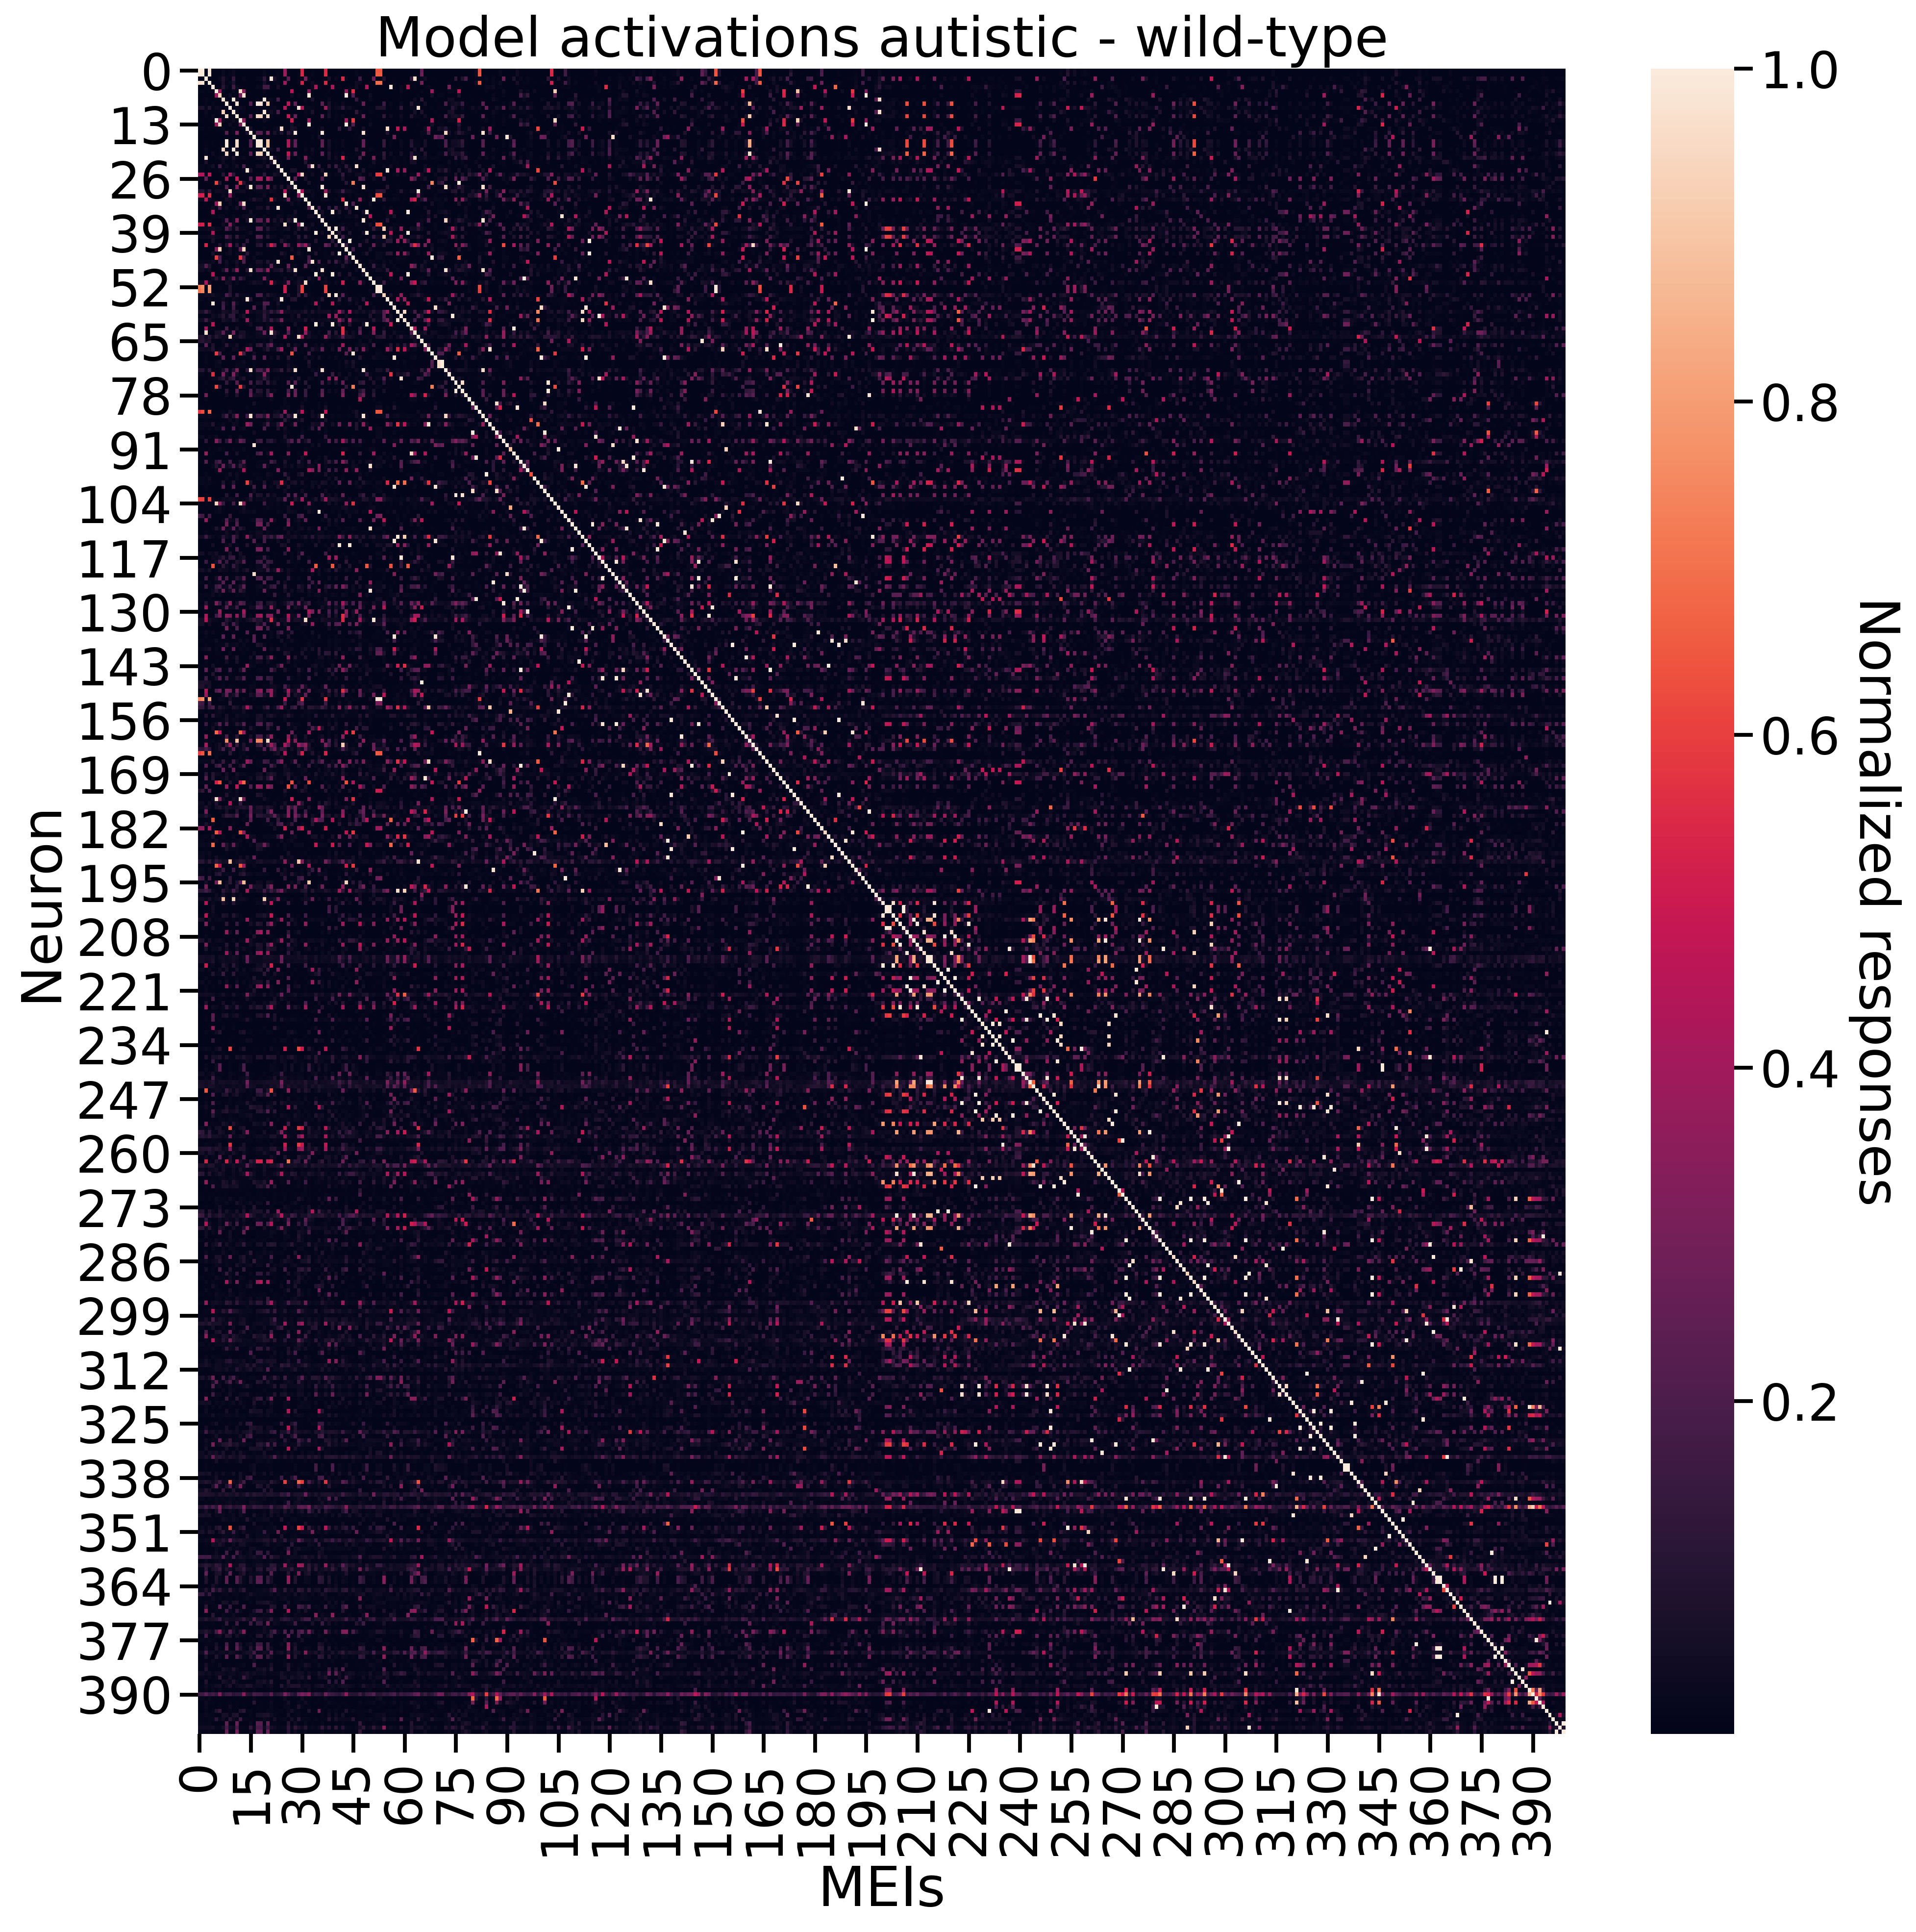

In [16]:
sns.set_context("talk", font_scale=1.5)
plt.figure(figsize=(15,15), dpi=300)
plt.title("Model activations autistic - wild-type")
ax = sns.heatmap(activations)
plt.xlabel("MEIs")
plt.ylabel("Neuron")
color_bar = ax.collections[0].colorbar
color_bar.set_label('Normalized responses', rotation=270, labelpad=30)
plt.savefig("Plots/HeatmapMEIsAUTWT.png")

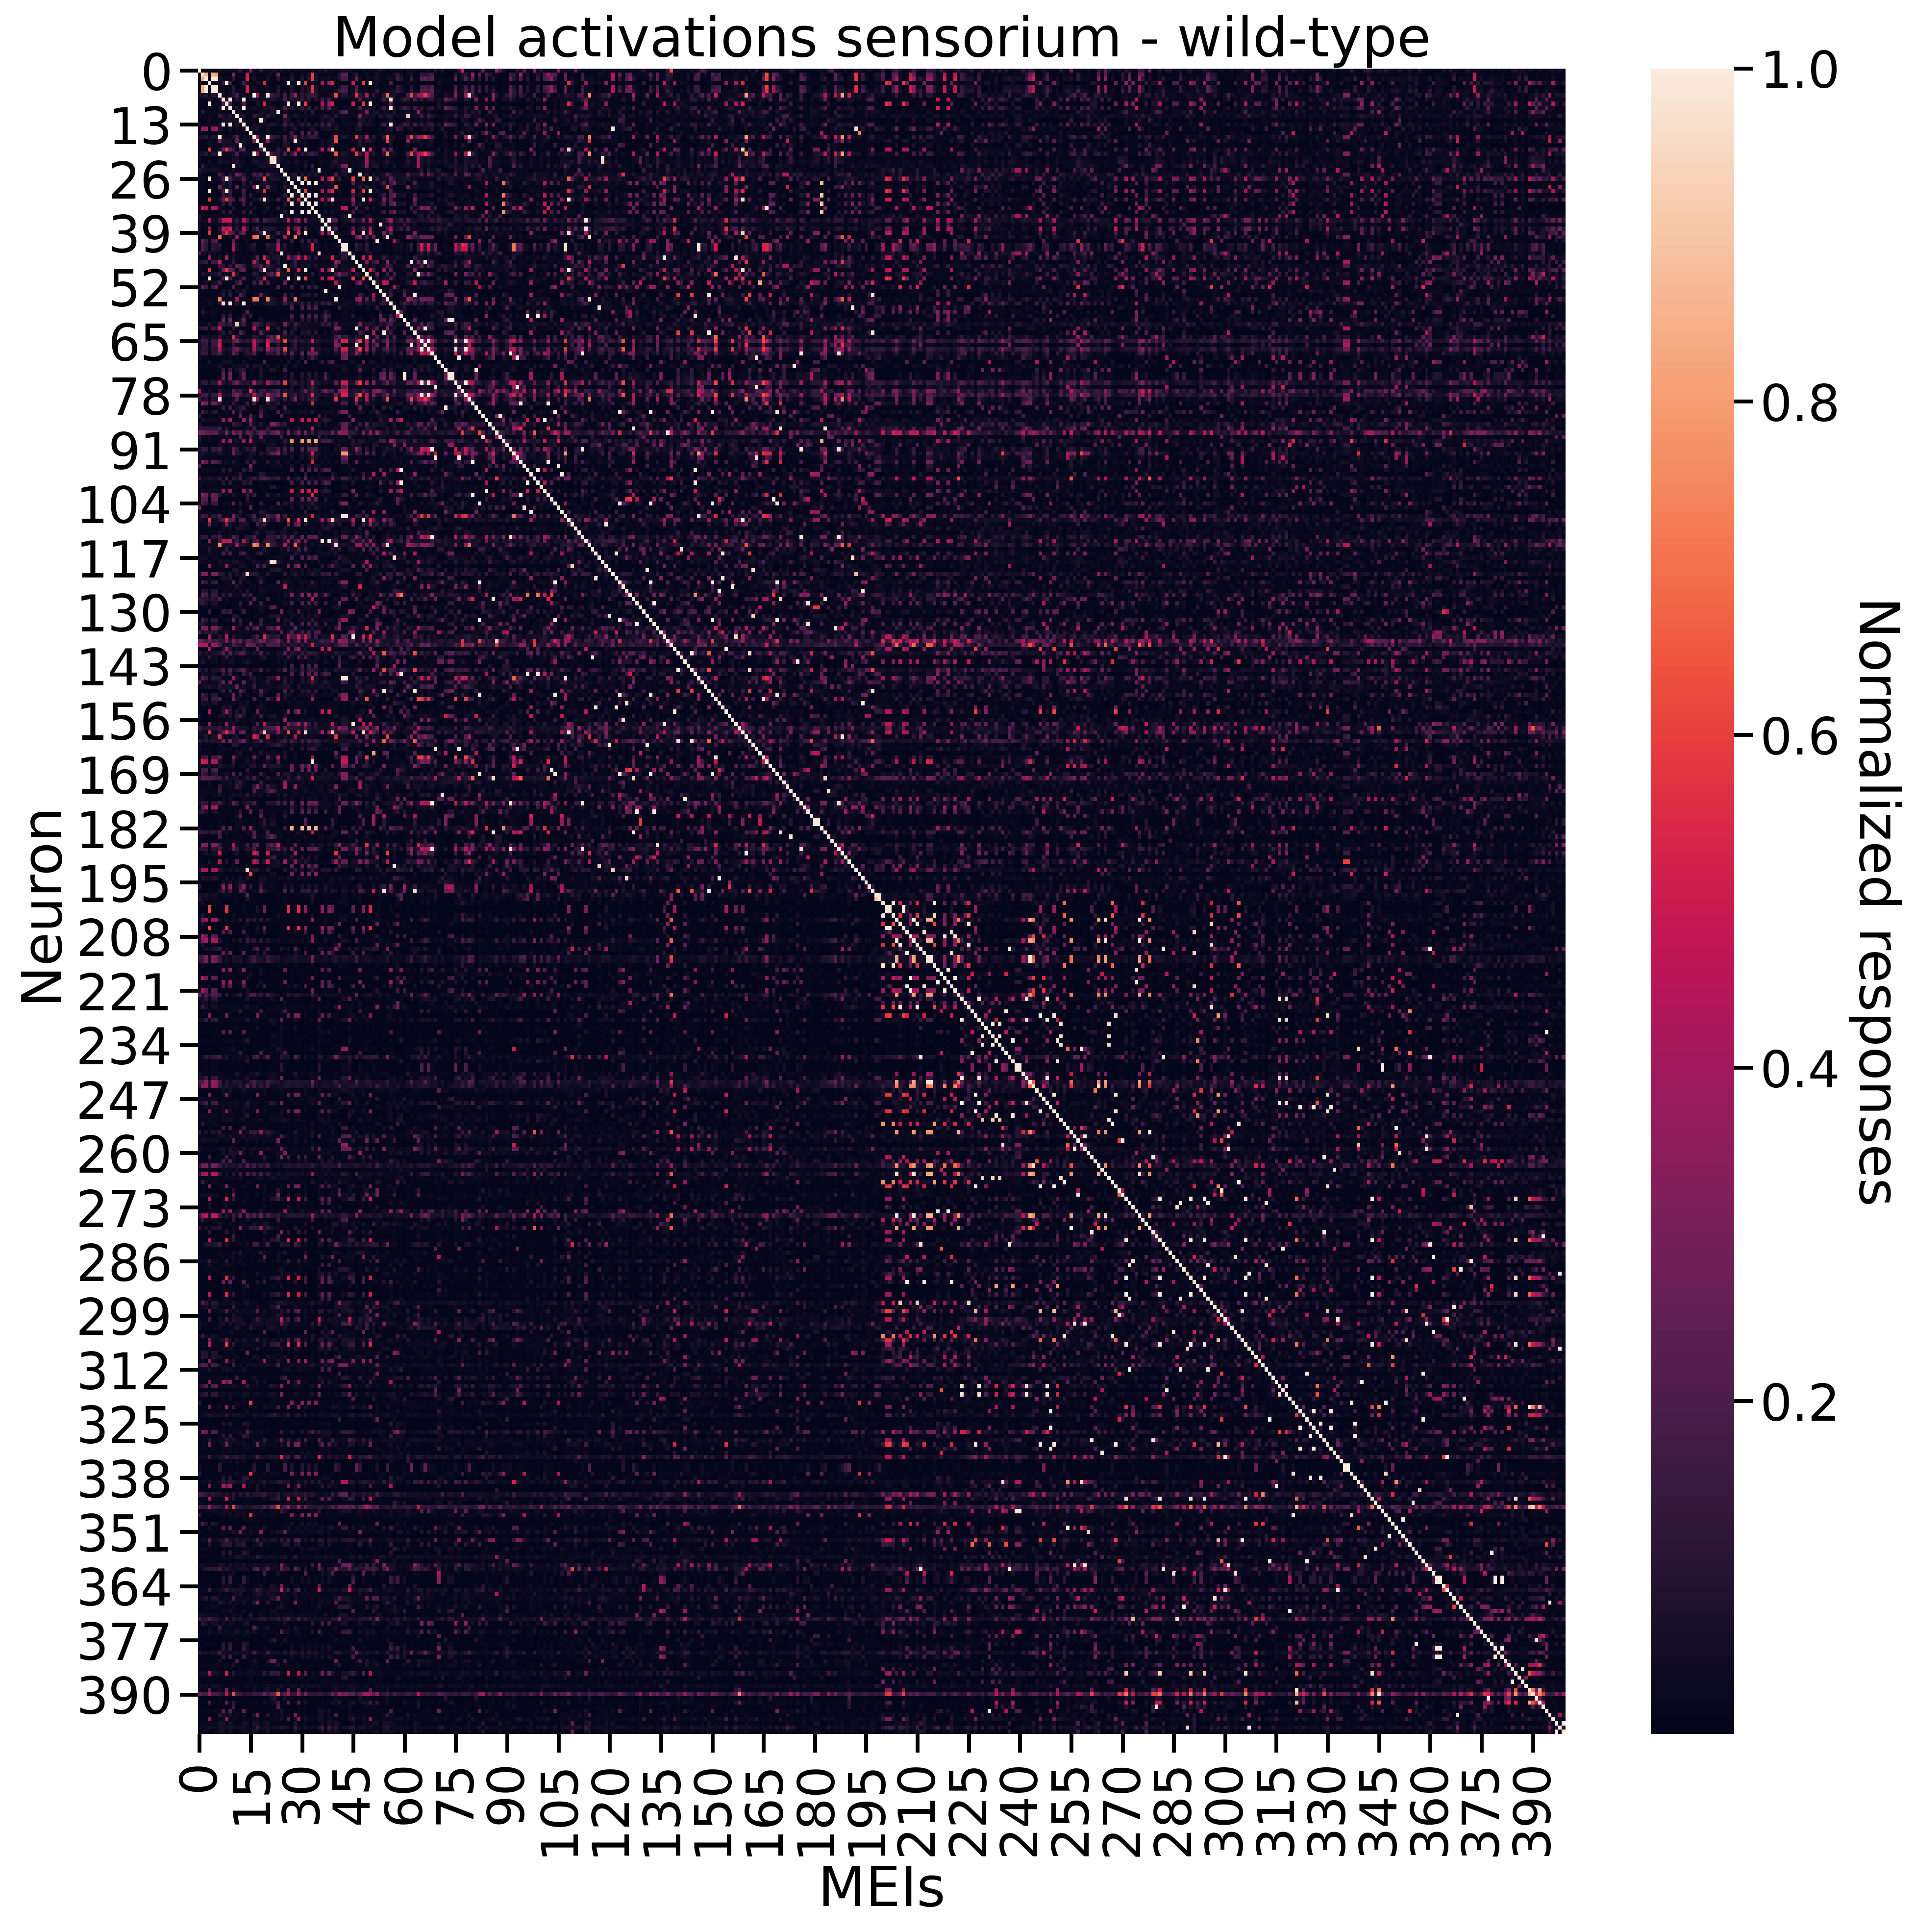

In [17]:
sns.set_context("talk", font_scale=1.5)
plt.figure(figsize=(15,15), dpi=300)
plt.title("Model activations sensorium - wild-type")
ax = sns.heatmap(activations_swt)
plt.xlabel("MEIs")
plt.ylabel("Neuron")
color_bar = ax.collections[0].colorbar
color_bar.set_label('Normalized responses', rotation=270, labelpad=30)
plt.savefig("Plots/HeatmapMEIsSENSWT.png")

## Extracting the off-diagonal normalized activations

In [18]:
aut_aut = []
wt_wt = []
aut_wt = []
wt_aut = []
for i in range(200):
    aut_aut.append(activations_a_list[i][:200])
    wt_wt.append(activations_wt_list[i][200:400])
    aut_wt.append(activations_a_list[i][200:400])
    wt_aut.append(activations_wt_list[i][:200])
aut_aut = np.array(aut_aut).reshape(200,200)
wt_wt = np.array(wt_wt).reshape(200,200)
aut_wt = np.array(aut_wt).reshape(200,200)
wt_aut = np.array(wt_aut).reshape(200,200)

In [19]:
np.fill_diagonal(aut_aut,np.nan)
np.fill_diagonal(wt_wt,np.nan)
np.fill_diagonal(aut_wt,np.nan)
np.fill_diagonal(wt_aut,np.nan)

In [20]:
aut_aut = aut_aut[~np.isnan(aut_aut)]
wt_wt = wt_wt[~np.isnan(wt_wt)]
aut_wt = aut_wt[~np.isnan(aut_wt)]
wt_aut = wt_aut[~np.isnan(wt_aut)]

In [21]:
sens_sens = []
sens_wt = []
wt_sens = []
for i in range(200):
    sens_sens.append(activations_s_list[i][:200])
    sens_wt.append(activations_s_list[i][200:400])
    wt_sens.append(activations_wtsens_list[i][:200])
sens_sens = np.array(sens_sens).reshape(200,200)
sens_wt = np.array(sens_wt).reshape(200,200)
wt_sens = np.array(wt_sens).reshape(200,200)

np.fill_diagonal(sens_sens,np.nan)
np.fill_diagonal(sens_wt,np.nan)
np.fill_diagonal(wt_sens,np.nan)

sens_sens = sens_sens[~np.isnan(sens_sens)]
sens_wt = sens_wt[~np.isnan(sens_wt)]
wt_sens = wt_sens[~np.isnan(wt_sens)]

## Plotting the off-diagonal normalized activations for all intra-model blocks.

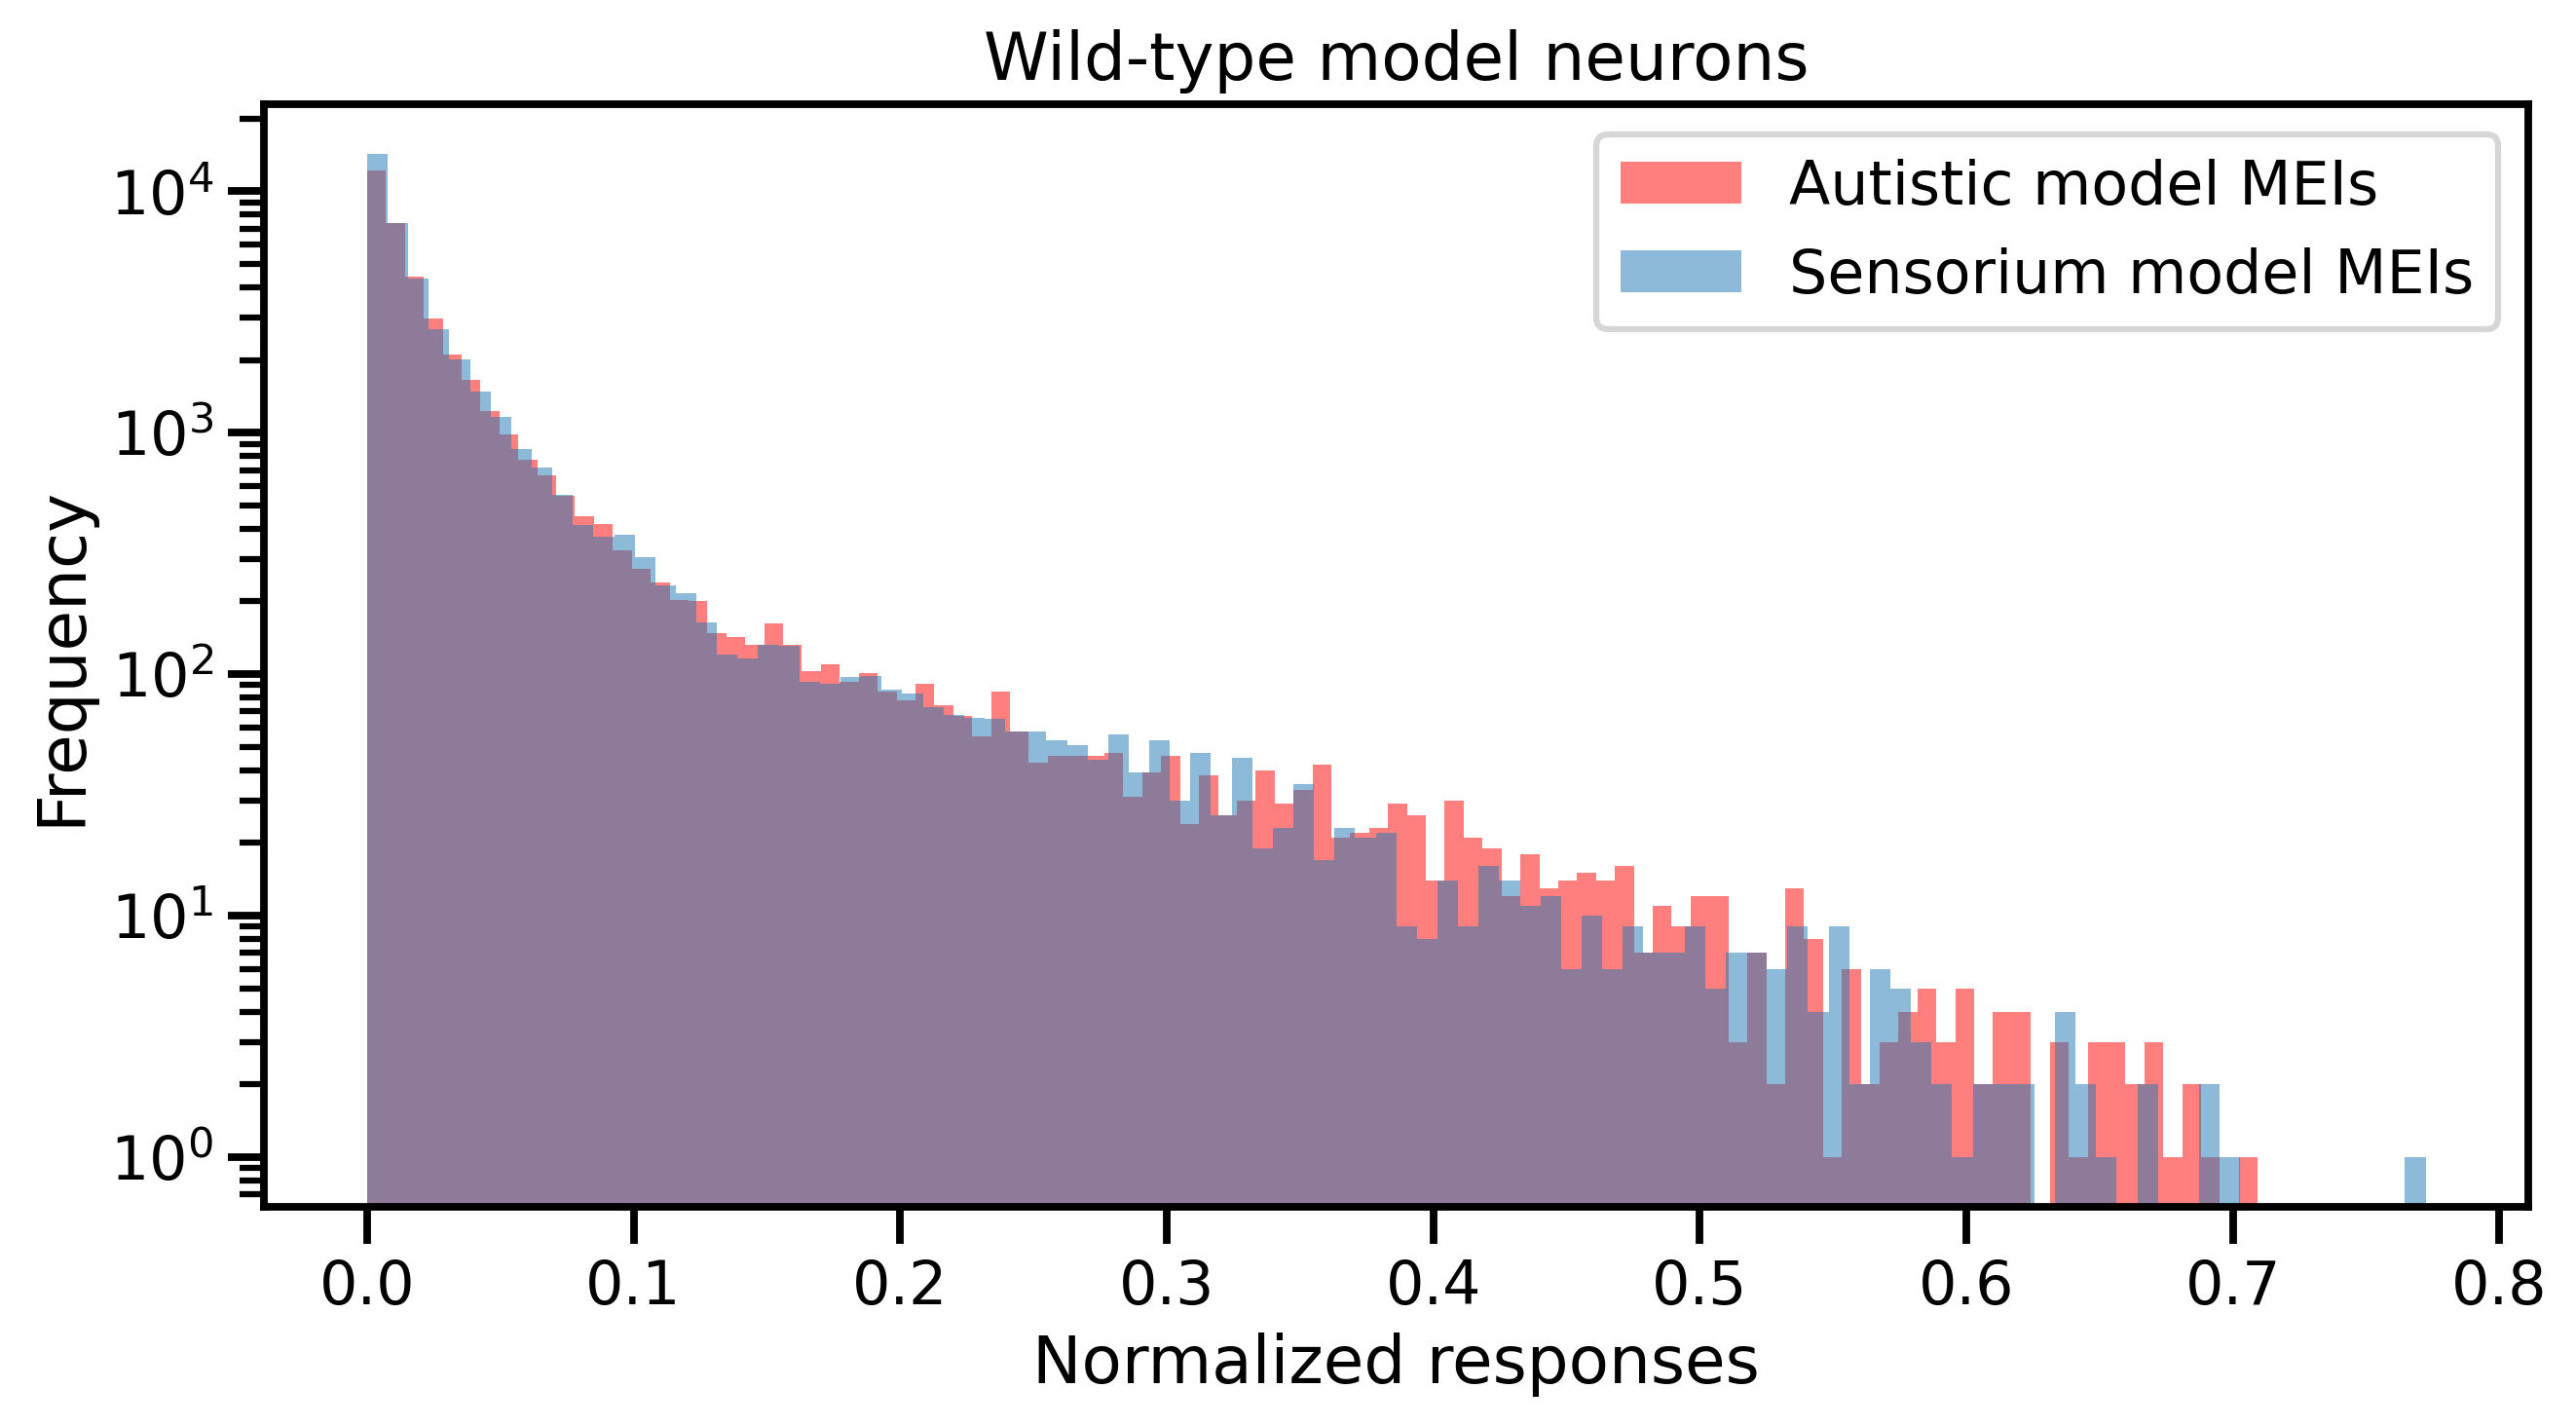

In [22]:
sns.set_context("talk", font_scale=0.9)
plt.figure(figsize=(10,5), dpi=300)
plt.title("Wild-type model neurons")
plt.hist(wt_aut, bins=100, color="red", alpha=0.5, label="Autistic model MEIs")
plt.hist(wt_sens, bins=100, alpha=0.5, label="Sensorium model MEIs")
plt.legend()
plt.yscale("log")
plt.xlabel("Normalized responses")
plt.ylabel("Frequency")
plt.savefig("Plots/WTModelComparison.png", dpi=300)

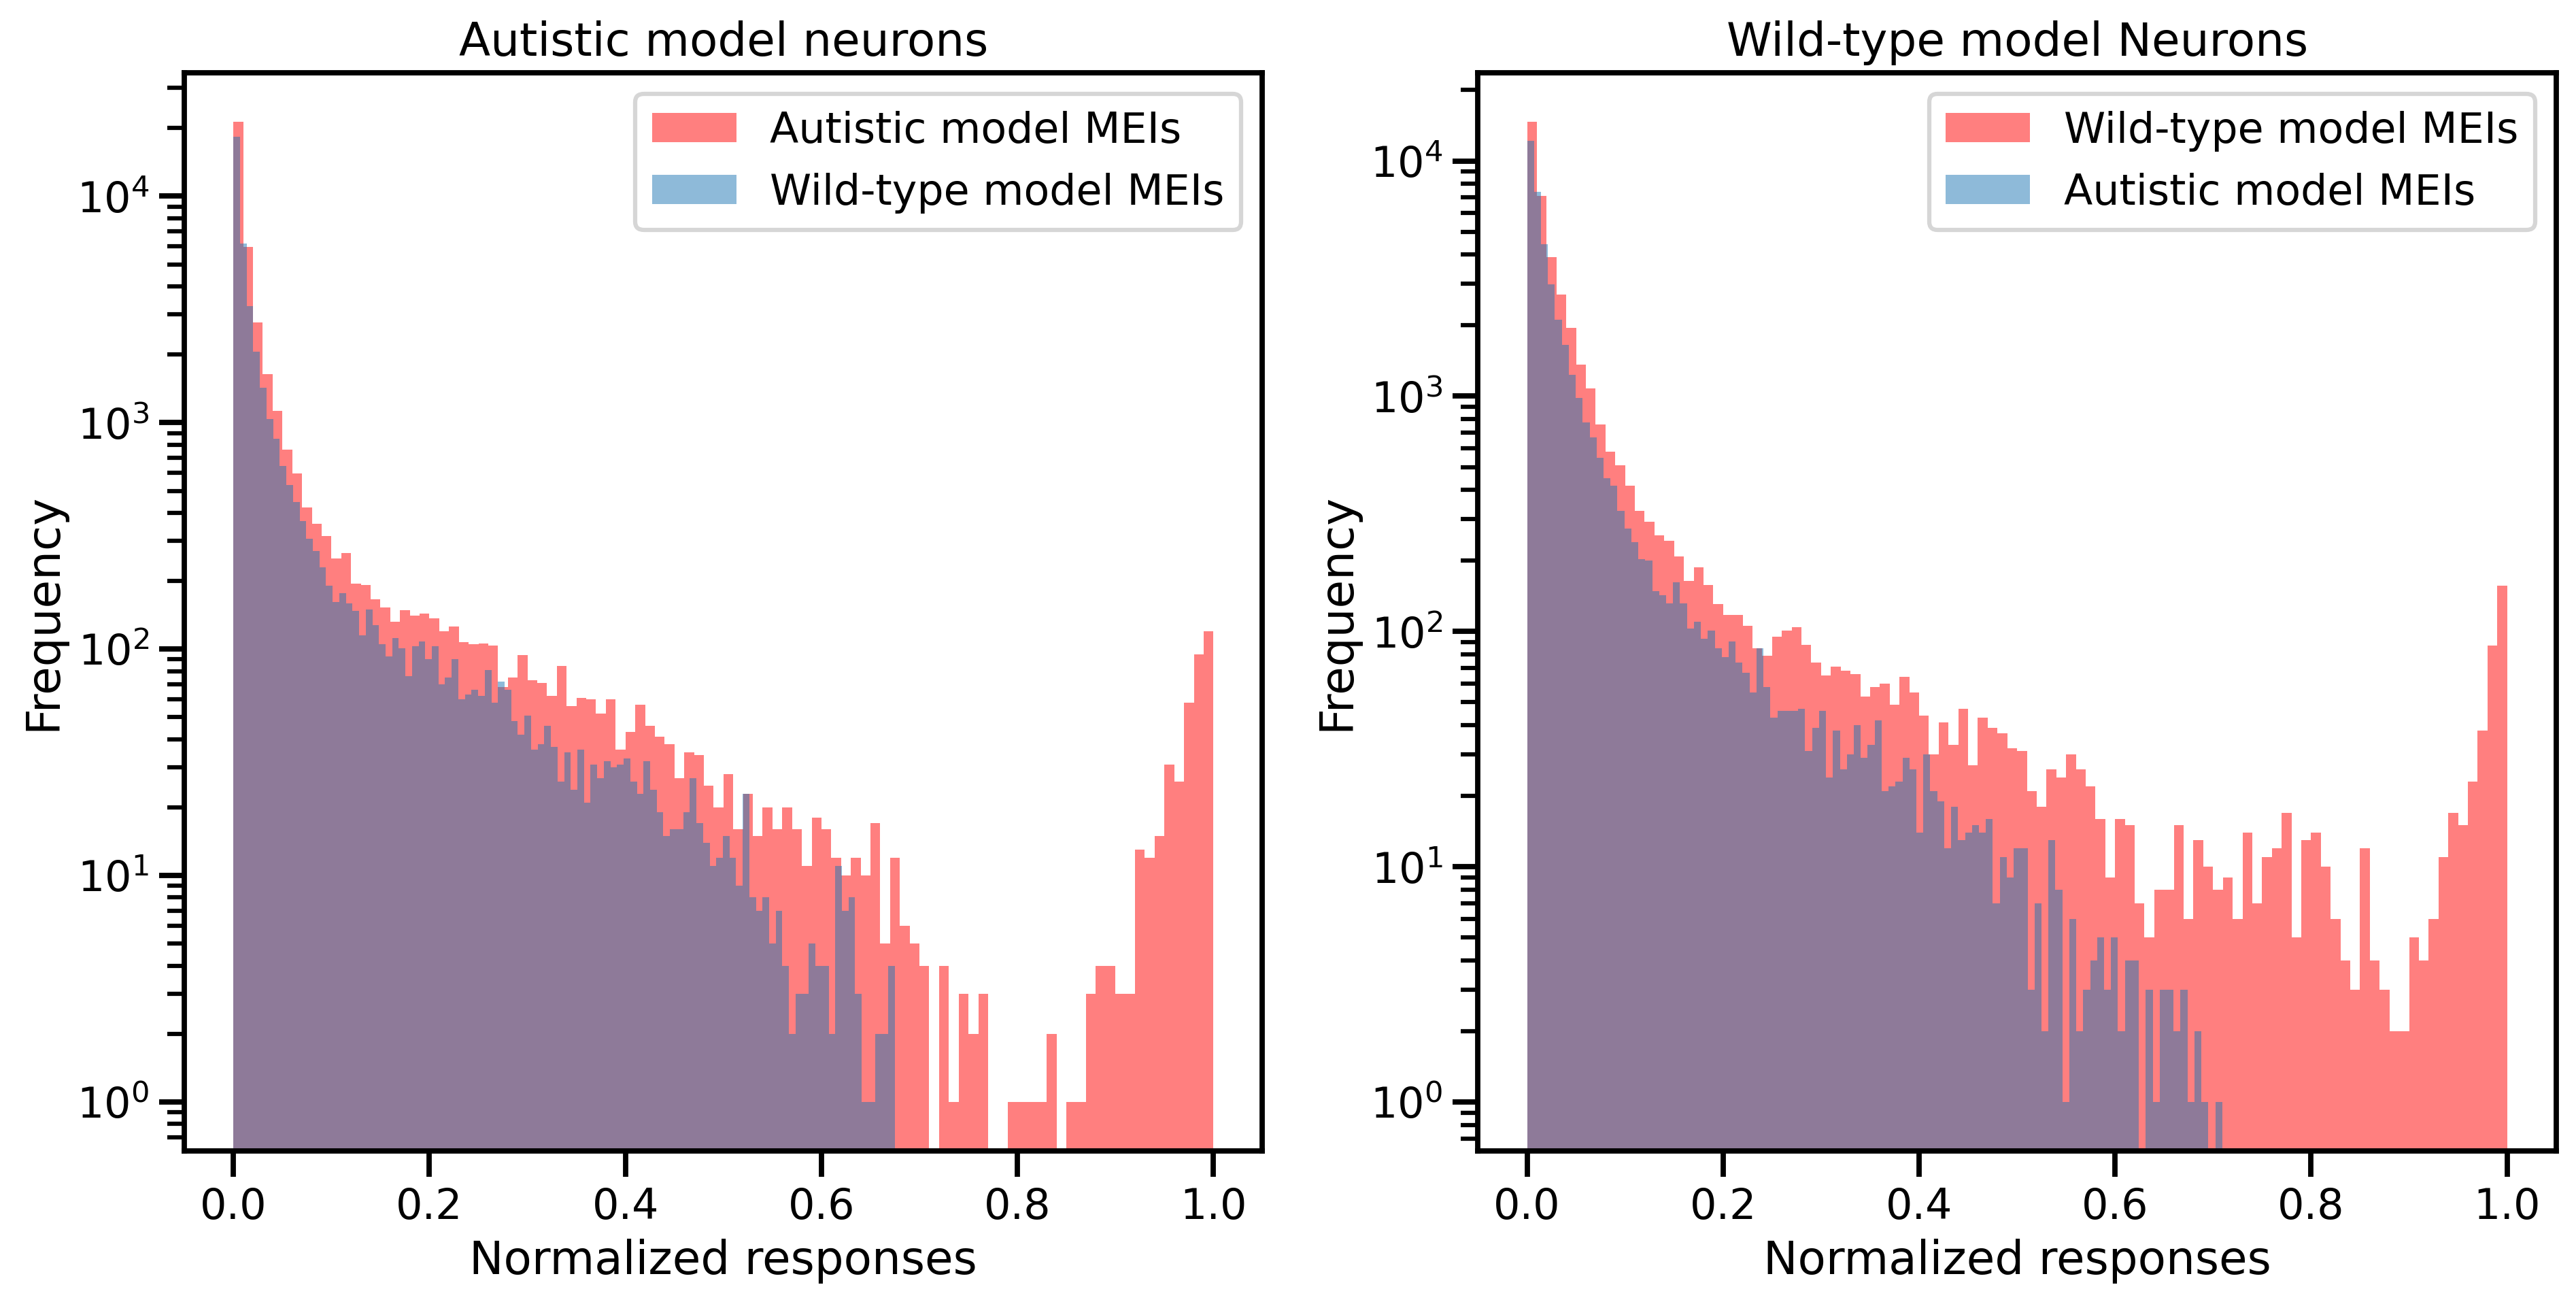

In [23]:
plt.figure(figsize=(15,7), dpi=300)

plt.subplot(1,2,1)
plt.title("Autistic model neurons")
plt.hist(aut_aut, bins=100, color="red", alpha=0.5, label="Autistic model MEIs")
plt.hist(aut_wt, bins=100, alpha=0.5, label="Wild-type model MEIs")
plt.legend()
plt.yscale("log")
plt.xlabel("Normalized responses")
plt.ylabel("Frequency")

plt.subplot(1,2,2)
plt.title("Wild-type model Neurons")
plt.hist(wt_wt, bins=100, color="red", alpha=0.5, label="Wild-type model MEIs")
plt.hist(wt_aut, bins=100, alpha=0.5, label="Autistic model MEIs");
plt.legend()
plt.yscale("log")
plt.xlabel("Normalized responses")
plt.ylabel("Frequency")
plt.savefig("Plots/NRCIB_AUT_WT.png", dpi=300)
